# okcdodgers Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [2]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [4]:
lkupclientid = 47 # okcdodgers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9443 entries, 0 to 9442
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              9443 non-null   int64  
 1   dimCustomerMasterId       9443 non-null   int64  
 2   customerNumber            9443 non-null   object 
 3   year                      9443 non-null   object 
 4   productGrouping           9443 non-null   object 
 5   totalSpent                9439 non-null   float64
 6   recentDate                9443 non-null   object 
 7   attendancePercent         9443 non-null   float64
 8   renewedBeforeDays         9443 non-null   int64  
 9   isBuyer                   9443 non-null   object 
 10  source_tenure             9443 non-null   int64  
 11  tenure                    9443 non-null   int64  
 12  distToVenue               9443 non-null   float64
 13  totalGames                9443 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [5]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9443 entries, 0 to 9442
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          9443 non-null   int64  
 1   dimCustomerMasterId   9443 non-null   int64  
 2   customerNumber        9443 non-null   object 
 3   year                  9443 non-null   object 
 4   productGrouping       9443 non-null   object 
 5   totalSpent            9439 non-null   float64
 6   recentDate            9443 non-null   object 
 7   attendancePercent     9443 non-null   float64
 8   renewedBeforeDays     9443 non-null   int64  
 9   isBuyer               9443 non-null   object 
 10  source_tenure         9443 non-null   int64  
 11  tenure                9443 non-null   int64  
 12  distToVenue           9443 non-null   float64
 13  totalGames            9443 non-null   int64  
 14  recency               9443 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [6]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (8499, 48)
Unseen Data For Predictions: (944, 48)
Data for Modeling (A Class): (8499, 48)
Unseen Data For Predictions: (944, 48)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [7]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(9443, 26)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [8]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9443 entries, 0 to 9442
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  9443 non-null   int64  
 1   totalSpent           9439 non-null   float64
 2   attendancePercent    9443 non-null   float64
 3   renewedBeforeDays    9443 non-null   int64  
 4   source_tenure        9443 non-null   int64  
 5   tenure               9443 non-null   int64  
 6   distToVenue          9443 non-null   float64
 7   totalGames           9443 non-null   int64  
 8   missed_games_1       9443 non-null   int64  
 9   missed_games_2       9443 non-null   int64  
 10  missed_games_over_2  9443 non-null   int64  
 11  email                9443 non-null   int64  
 12  outbound_phonecall   9443 non-null   int64  
 13  phonecall            9443 non-null   int64  
 14  isNextYear_Buyer     9443 non-null   int64  
dtypes: float64(3), int64(12)
memory usage:

### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,totalGames,missed_games_1,missed_games_2,missed_games_over_2,email,outbound_phonecall,phonecall,isNextYear_Buyer
dimCustomerMasterId,1.00,0.12,-0.07,0.13,0.15,0.34,-0.09,0.15,0.09,0.10,0.11,0.21,0.16,0.16,0.25
totalSpent,0.12,1.00,-0.09,0.14,0.18,0.15,-0.02,0.73,0.41,0.41,0.63,0.01,-0.03,-0.03,0.11
attendancePercent,-0.07,-0.09,1.00,-0.38,-0.25,-0.11,0.10,0.09,0.04,-0.07,-0.39,0.08,0.10,0.10,-0.08
renewedBeforeDays,0.13,0.14,-0.38,1.00,0.42,0.06,-0.10,0.19,0.16,0.20,0.30,-0.25,-0.18,-0.17,0.22
source_tenure,0.15,0.18,-0.25,0.42,1.00,0.33,-0.14,0.20,0.14,0.16,0.27,-0.07,-0.07,-0.07,0.24
tenure,0.34,0.15,-0.11,0.06,0.33,1.00,-0.11,0.18,0.09,0.08,0.14,0.53,0.33,0.33,0.20
distToVenue,-0.09,-0.02,0.10,-0.10,-0.14,-0.11,1.00,0.02,-0.01,-0.03,-0.06,-0.03,-0.02,-0.02,-0.10
totalGames,0.15,0.73,0.09,0.19,0.20,0.18,0.02,1.00,0.66,0.56,0.62,0.01,-0.02,-0.02,0.16
missed_games_1,0.09,0.41,0.04,0.16,0.14,0.09,-0.01,0.66,1.00,0.41,0.29,-0.04,-0.05,-0.05,0.10
missed_games_2,0.10,0.41,-0.07,0.20,0.16,0.08,-0.03,0.56,0.41,1.00,0.33,-0.04,-0.05,-0.05,0.11


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (7554, 15)
Unseen Data For Predictions: (1889, 15)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=["totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "email",
        "outbound_phonecall",
        "phonecall"
    ]
)

,Description,Value
0,session_id,339
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(7554, 15)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(-1,
 [],
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 7549    1
 7550    0
 7551    0
 7552    0
 7553    1
 Name: isNextYear_Buyer, Length: 7554, dtype: int64,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_groups_param_full',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_targe

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8168,0.8947,0.7291,0.7628,0.7452,0.6024,0.6031,0.0450
9,Extreme Gradient Boosting,0.8167,0.8915,0.7471,0.7527,0.7497,0.6051,0.6053,0.4590
2,Gradient Boosting Classifier,0.8152,0.8900,0.7453,0.7508,0.7478,0.6020,0.6022,0.1710
7,Random Forest Classifier,0.8150,0.8873,0.7250,0.7609,0.7423,0.5982,0.5988,0.2690
3,Extra Trees Classifier,0.8013,0.8701,0.7102,0.7397,0.7242,0.5691,0.5697,0.2410
8,NGBClassifier,0.7994,0.8777,0.7232,0.7310,0.7263,0.5681,0.5690,2.0190
0,Ada Boost Classifier,0.7925,0.8683,0.6818,0.7357,0.7072,0.5470,0.5483,0.0640
1,Decision Tree Classifier,0.7566,0.7373,0.6643,0.6706,0.6670,0.4753,0.4756,0.0120
4,K Neighbors Classifier,0.6896,0.7229,0.5288,0.5864,0.5554,0.3181,0.3196,0.0510
6,Logistic Regression,0.6323,0.3154,0.0000,0.0000,0.0000,0.0000,0.0000,0.0070


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7983,0.8797,0.6982,0.7381,0.7176,0.5610,0.5615
1,0.8413,0.9107,0.7534,0.8038,0.7778,0.6546,0.6554
2,0.8066,0.8899,0.6861,0.7650,0.7234,0.5754,0.5774
3,0.8411,0.8967,0.7703,0.7917,0.7808,0.6562,0.6563
4,0.8278,0.9019,0.7568,0.7706,0.7636,0.6282,0.6283
5,0.8195,0.9003,0.7117,0.7783,0.7435,0.6048,0.6062
6,0.8245,0.9102,0.7568,0.7636,0.7602,0.6218,0.6218
7,0.8129,0.8862,0.7072,0.7659,0.7354,0.5910,0.5922
8,0.7914,0.8806,0.6892,0.7286,0.7083,0.5462,0.5467
9,0.8046,0.8911,0.7613,0.7222,0.7412,0.5845,0.5850


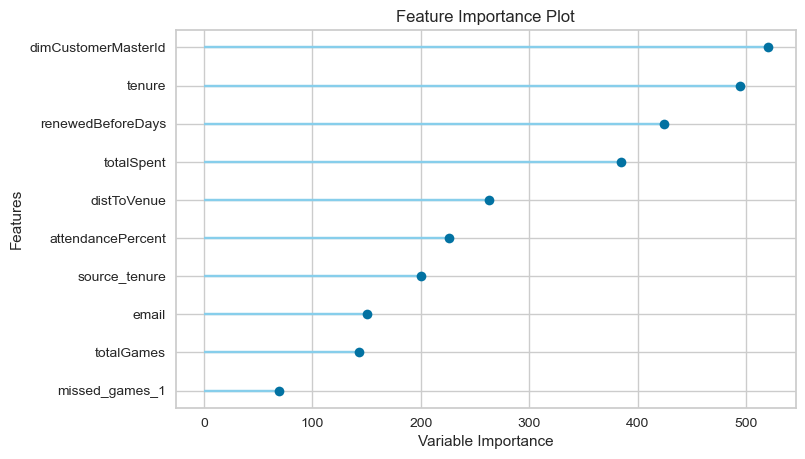

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?